<h1><center> Frontal Low-Level Jet analysis  </center></h1>
<div style="text-align: center"> 
    Dr. Harish Baki <br/> Postdoctoral researcher <br/> TU Delft, Netherlands <br/> Email: h.baki@tudelft.nl<br/>
</div>

In [1]:
# print current date
import datetime
print(f'Updated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Updated: 2024-05-03 15:19:08


In [2]:
import xarray as xr
from netCDF4 import Dataset
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import wrf
from wrf import interplevel

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import HourLocator, DateFormatter, MinuteLocator

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2

import wrf
from wrf import (getvar, interplevel, vertcross,
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 interpline, ll_to_xy,extract_global_attrs)

root_dir = '/media/harish/SSD_4TB/EU_SCORES_project/WRFV4.4/FLLJ'
scripts_dir = f'{root_dir}/scripts'
sys.path.append(scripts_dir)

from data_processing.libraries import *

In [8]:
fig_dir = '/home/harish/Dropbox/Apps/Overleaf/Modelling Frontal Low-level Jets and Associated Extreme Wind Ramps'
buoy_locations = {'LOT1': [51.706898,3.034618], 'LOT2': [51.6463,2.95141]}

run_names = ['ERA5-MYFP','CERRA-MYFP','CERRA-MYnoFP','CERRA-SH','CERRA-MYFP1d','CERRA-SH0.5km','CERRA-SH0.5km1d','GFS-MYFP']
domains = ['d03', 'd02', 'd02', 'd02','d01','d02','d01','d03']
time_instances = ['2016-02-22T06:00','2016-03-04T07:30']
contour_levels = [np.arange(0, 30.1, 2),np.arange(0,30.1,2)]
angles = [165,450]

# Spatial wind barbs

In [45]:
def plot_wind_barbs(fig, gs, u_data, v_data, XLONG, XLAT, n, title,contour_levels=None,normal_and_parallel=False,XLONG_line=None,XLAT_line=None,XLONG_nline=None,XLAT_nline=None,xlabel=None, ylabel=None):
    axs0 = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    
    # Calculate wind speed
    ws = wind_speed(u_data, v_data)
    
    # Create a colormap based on wind speed
    cmap = plt.get_cmap('tab20c')  # You can choose any colormap you prefer
    norm = mcolors.Normalize(vmin=contour_levels.min(), vmax=contour_levels.max())
    
    # Plot wind barbs
    barb_plot = axs0.barbs(XLONG[::n, ::n], 
                           XLAT[::n, ::n], 
                           u_data[::n, ::n], 
                           v_data[::n, ::n],
                           ws[::n, ::n], cmap=cmap, norm=norm,
                           length=5, transform=ccrs.PlateCarree())
    
    extent = [XLONG.min(), XLONG.max(), XLAT.min(), XLAT.max()]
    axs0.set_extent(extent, crs=ccrs.PlateCarree())

    # Set title and labels
    if title is not None:
        axs0.set_title(title, fontsize=16)

    if normal_and_parallel == 1:
        #Add cross section line
        axs0.plot(XLONG_line.values, XLAT_line.values, color='red', transform=ccrs.PlateCarree(), linewidth=1)
        #Add normal to the cross section line
        #axs0.plot(XLONG_nline.values, XLAT_nline.values, color='red', transform=ccrs.PlateCarree(), linewidth=1, linestyle='dashed')
        #Add A and B at the ends of the line
        axs0.text(XLONG_line.values[0], XLAT_line.values[0]+0.01, 'B', color='black', transform=ccrs.PlateCarree(), fontsize=12)
        axs0.text(XLONG_line.values[-1]-0.1, XLAT_line.values[-1]-0.3, 'A', color='black', transform=ccrs.PlateCarree(), fontsize=12)
    elif normal_and_parallel == 2:
        #Add cross section line
        axs0.plot(XLONG_line.values, XLAT_line.values, color='red', transform=ccrs.PlateCarree(), linewidth=1)
        axs0.text(XLONG_line.values[0], XLAT_line.values[0]+0.01, 'A', color='black', transform=ccrs.PlateCarree(), fontsize=12)
        axs0.text(XLONG_line.values[-1]-0.1, XLAT_line.values[-1]-0.3, 'B', color='black', transform=ccrs.PlateCarree(), fontsize=12)
    
    # Add the observational location
    axs0.scatter(buoy_locations['LOT1'][1],buoy_locations['LOT1'][0], color='black', marker='*', transform=ccrs.PlateCarree(), s=50)
    axs0.scatter(buoy_locations['LOT2'][1],buoy_locations['LOT2'][0], color='black', marker='*', transform=ccrs.PlateCarree(), s=50)

    # Add coastlines and gridlines
    axs0.coastlines()
    
    # Adjust the placement of gridline labels
    gl = axs0.gridlines(draw_labels=True)
    gl.top_labels = False  # Disable top labels for latitude
    gl.right_labels = False  # Disable right labels for longitude

    # cartopy fails to add the xlabel and label
    if ylabel is not None:
        axs0.text(-0.25, 0.55, ylabel, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axs0.transAxes, fontsize=12)
    
    return barb_plot

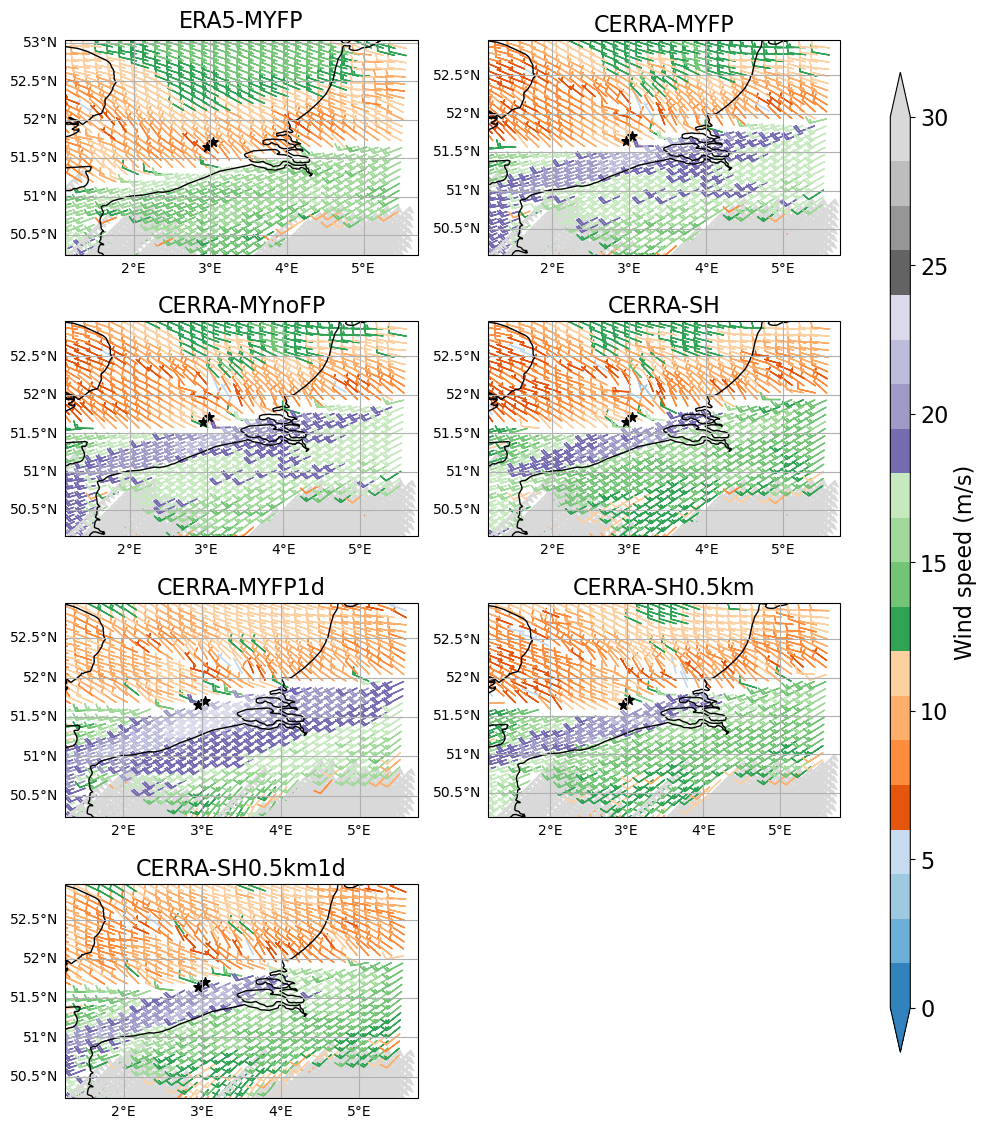

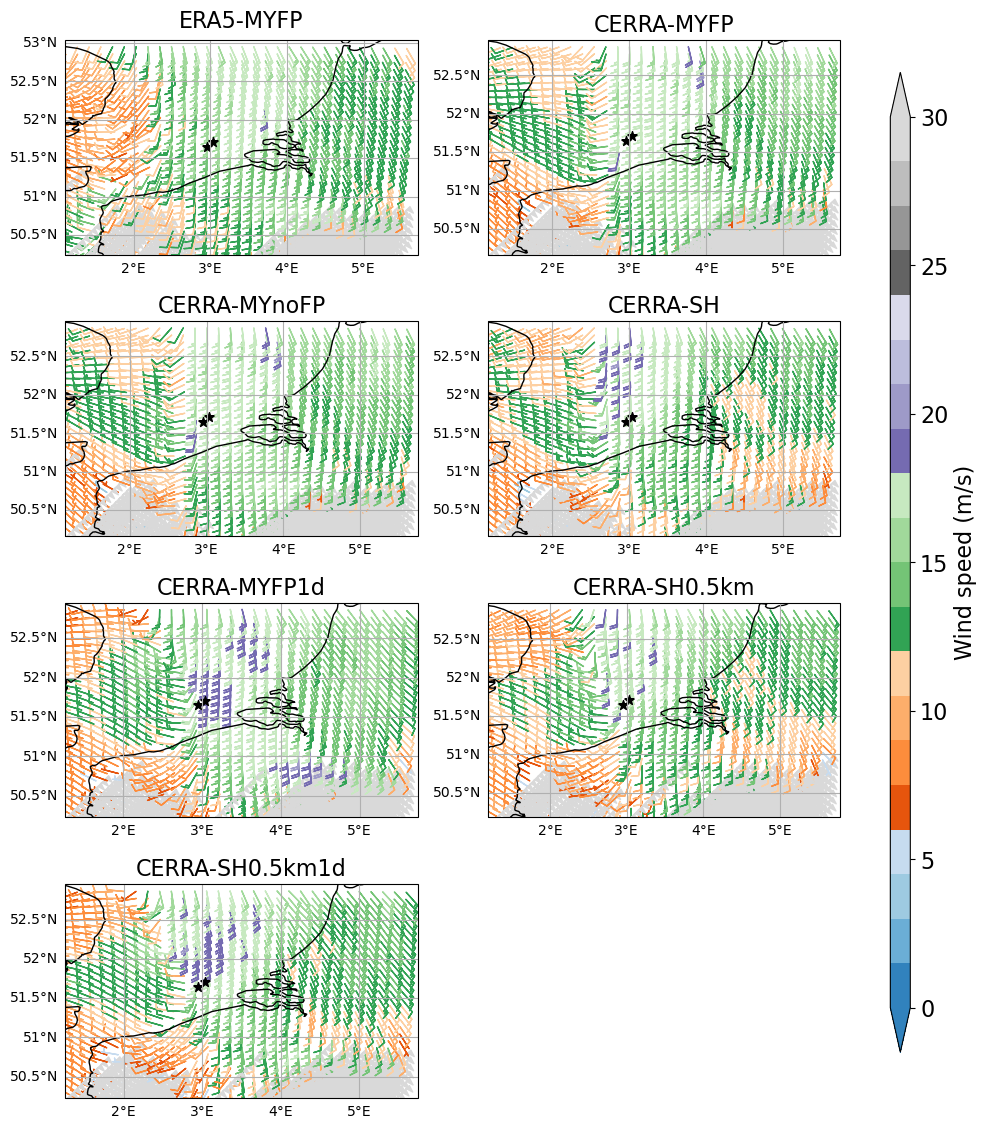

In [41]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    fig = plt.figure(figsize=(10, 14))
    gs = plt.GridSpec(4,2)
    for run in range(1,8):
        u_data, v_data, XLONG, XLAT = extract_u_v(root_dir, case_dir,run,time_instances[case-1],levels=100.0)
        u_data = u_data.squeeze()
        v_data = v_data.squeeze()
        n = 20 if run == 6 or run == 7 else 10
        title = run_names[run-1]

        axs = plot_wind_barbs(fig, gs[(run-1)//2,(run-1)%2], u_data, v_data, XLONG, XLAT,n,title,contour_levels[case-1])

    # Adding colorbar
    cbarb_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(axs, cax=cbarb_ax, orientation='vertical',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.yaxis.label.set_fontsize(16)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='y', labelsize=16)

    # save figure
    plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_barbs_during_{time_instances[case-1]}.pdf', dpi=300, bbox_inches='tight')

In [41]:
def compute_normal_parallel(u_cross, v_cross, angle_degrees):
    '''
    Takes u and v components, and computes tangent and normal components at an angle
    returns transact normal and transact parallel components, which are indeed front parallel and front normal components
    '''
    angle_radians = np.radians(angle_degrees)
    normal_vector = np.array([np.cos(angle_radians), np.sin(angle_radians)])
    parallel_vector = np.array([-np.sin(angle_radians), np.cos(angle_radians)])
    
    # Calculate the tangent and normal components
    transact_normal_component = u_cross * normal_vector[0] + v_cross * normal_vector[1]
    transact_parallel_component = -(u_cross * parallel_vector[0] + v_cross * parallel_vector[1])
    
    return transact_normal_component, transact_parallel_component

def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Computes the distance between two points
    If the 2nd point is a list, then computes the distance in positive, 0 , negative order, relative to the 1st point
    Since the line is calculated from bottom to top, but we want to present in top-to-bottom direction.
    Thus, assign positive distance before observation and negative after, while moving from bottom-to-top
    '''
    R = 6371000  # Earth radius in meters

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distance = distance/1000.0 #converting into km

    return distance

In [42]:
def get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,time_intances,levels, angle):

    u_data, v_data, XLONG, XLAT = extract_u_v(root_dir, case_dir,run,time_instances[case-1],levels=[1100.0])
    u_data = u_data.squeeze()
    v_data = v_data.squeeze()

    ind_y,ind_x = find_nearest_indice(XLAT, XLONG, buoy_locations['LOT1'][0],buoy_locations['LOT1'][1])
    pivot_point = CoordPair(ind_x,ind_y)

    # Interpolate XLAT and XLONG at the cross-sectional line, using pivot point and angle
    XLAT_line = interpline(XLAT, pivot_point=pivot_point, angle=angle,latlon=True)
    XLONG_line = interpline(XLONG, pivot_point=pivot_point, angle=angle,latlon=True)

    # Interpolate XLAT and XLONG normal to the cross-sectional line, using pivot point and angle
    XLAT_nline = interpline(XLAT, pivot_point=pivot_point, angle=angle-90,latlon=True)
    XLONG_nline = interpline(XLONG, pivot_point=pivot_point, angle=angle-90,latlon=True)

    # Get the line distance relative to LOT1_loc across cross-sectional line
    distances = haversine_distance(buoy_locations['LOT1'][0],buoy_locations['LOT1'][1], XLAT_line, XLONG_line)
    # Find the index of the minimum distance
    argmin_index = int(distances.argmin())

    # Create an array of adjusted distances
    line_distances = np.empty_like(distances)
    if case_dir == 'FLLJ_1':
        line_distances[:argmin_index] = distances[:argmin_index]
        line_distances[argmin_index:] = -distances[argmin_index:]
    else:
        line_distances[:argmin_index] = -distances[:argmin_index]
        line_distances[argmin_index:] = distances[argmin_index:]

    # Interpolate u and v at the cross-sectional line, using pivot point and angle
    u_cross = interpline(u_data, pivot_point=pivot_point, angle=angle, latlon=True)
    v_cross = interpline(v_data, pivot_point=pivot_point, angle=angle, latlon=True)

    # Assign line distances coordinates to to u and v cross-sections
    u_cross = u_cross.assign_coords(line_idx=line_distances)
    v_cross = v_cross.assign_coords(line_idx=line_distances)

    # Get the tangent and normal components for the cross-sectional line
    normal_component,parallel_component = compute_normal_parallel(u_cross, v_cross, angle-180)

    return u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component

In [46]:
def plot_cross_section(fig, gs, data, line_distances, title, xlabel, ylabel, contour_levels=None,cmap=None,case=None):
    ax = fig.add_subplot(gs)
    c_levels = contour_levels
    cmap = plt.get_cmap(cmap)  # You can choose any colormap you prefer
    norm = mcolors.Normalize(vmin=c_levels.min(), vmax=c_levels.max())
    contourf1 = data.plot.contourf(ax=ax,levels=c_levels, cmap=cmap,norm=norm, extend='both',add_colorbar=False)
    ax.set_yticks(data.num_z_levels_stag.values)

    ax.set_ylim(10, 1100)
    ax.set_yticks([10,100,200,500,700,900,1100])
    ax.set_xlabel(xlabel, fontsize=16) if xlabel is not None else ax.set_xlabel('')
    ax.set_ylabel(ylabel, fontsize=16) if ylabel is not None else ax.set_ylabel('')
    ax.set_title(title,fontsize=16) if title is not None else ax.set_title('')

    # Add labels "A" and "B"
    if case == 1:
        ax.text(line_distances[0]-15, 0, 'B', color='black', fontsize=14)
        ax.text(line_distances[-1], 0, 'A', color='black', fontsize=14)
    else:
        ax.text(line_distances[0], 0, 'A', color='black', fontsize=14)
        ax.text(line_distances[-1]-15, 0, 'B', color='black', fontsize=14)

    return contourf1

Closest indices in the order of latitude (y) and longitude (x) are : (155, 126)


Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)


Closest indices in the order of latitude (y) and longitude (x) are : (324, 239)


Closest indices in the order of latitude (y) and longitude (x) are : (323, 236)


Closest indices in the order of latitude (y) and longitude (x) are : (155, 126)


Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)


Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)


Closest indices in the order of latitude (y) and longitude (x) are : (324, 239)


Closest indices in the order of latitude (y) and longitude (x) are : (323, 236)


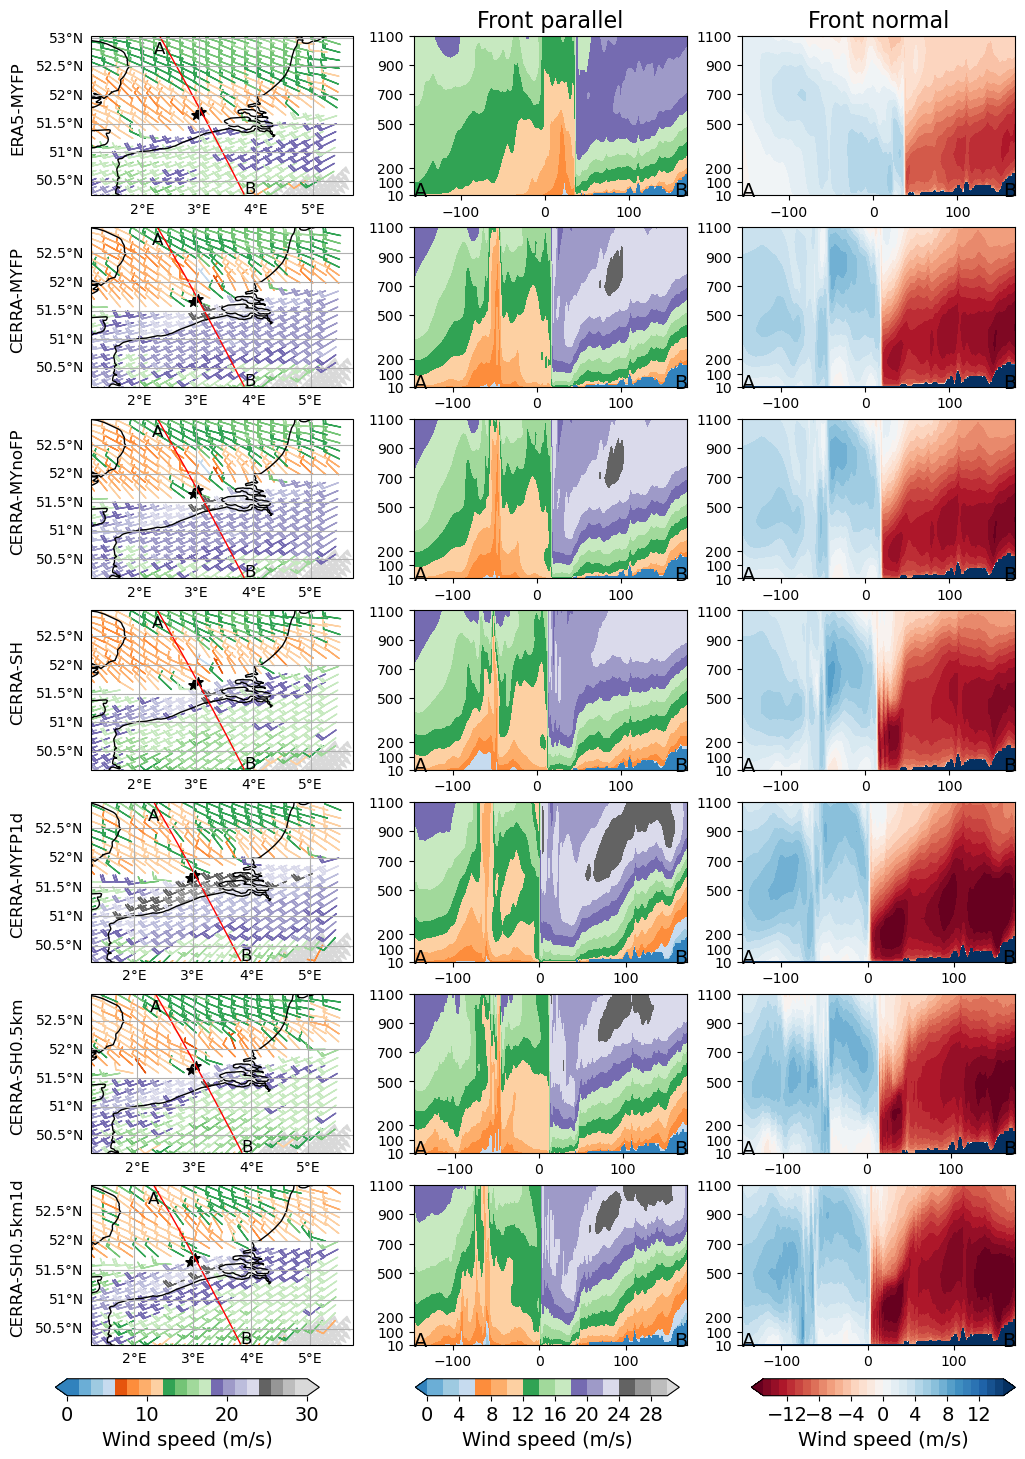

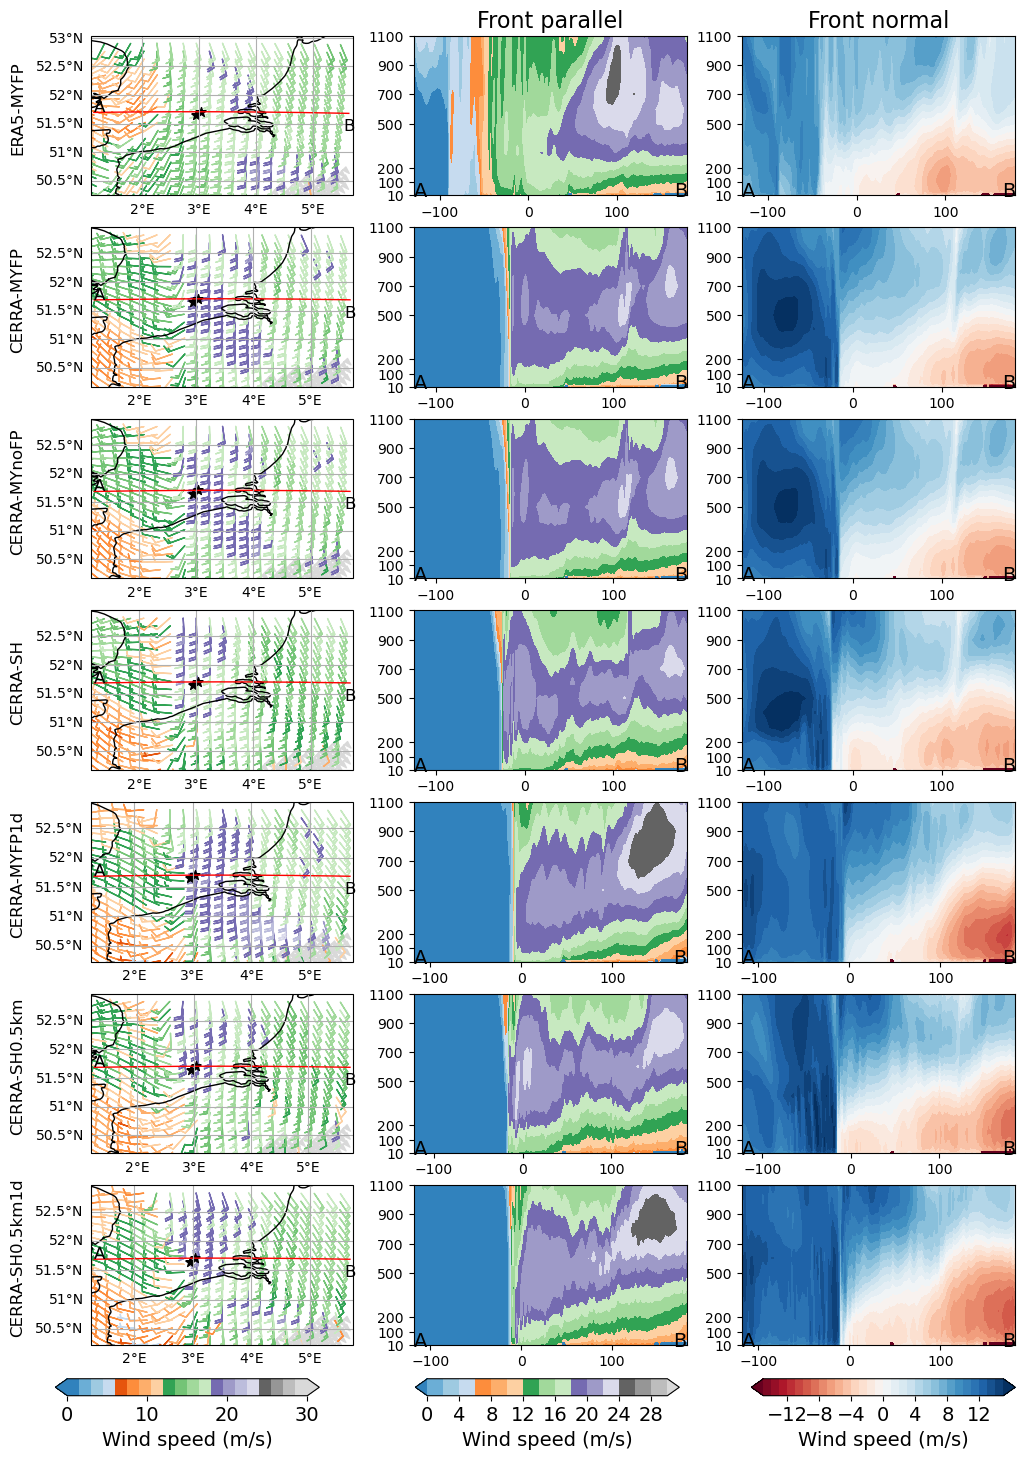

In [47]:
angles = [165,270]
for case in [1,2]:
    case_dir = f'FLLJ_{case}' 
    fig = plt.figure(figsize=(12, 17))
    gs = plt.GridSpec(7,3)
    angle = angles[case-1]

    for run in range(1,8):
        run_dir = f'WRF_run_{run}'
        u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component = get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,time_instances,[1100.0], angle)
        # == First figure - wind barbs ==##
        n = 30  if run == 6 or run == 7 else 15
        title = None
        ylabel = run_names[run-1]
        ax0 = plot_wind_barbs(fig, gs[run-1,0], u_data.sel(num_z_levels_stag=200.), v_data.sel(num_z_levels_stag=200.), XLONG, XLAT,n,title,contour_levels[case-1],
        normal_and_parallel=case,XLONG_line=XLONG_line,XLAT_line=XLAT_line,XLONG_nline=XLONG_nline,XLAT_nline=XLAT_nline,ylabel=ylabel)

        # == Second figure - normal component ==##
        data = normal_component
        title = 'Front parallel' if run == 1 else None
        ax1 = plot_cross_section(fig, gs[run-1,1], data, line_distances, title, None, None, contour_levels=np.arange(0, 31,2),cmap='tab20c',case=case)

        # == Third figure - parallel component ==##
        data = parallel_component
        title = 'Front normal' if run == 1 else None
        ax2 = plot_cross_section(fig, gs[run-1,2], data, line_distances, title, None, None, contour_levels=np.arange(-15, 16, 1),cmap='RdBu',case=case)

    # Adding colorbar for column 1 figures
    cbarb_ax = fig.add_axes([0.1, 0.08, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax0, cax=cbarb_ax, orientation='horizontal',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    cbarb_ax = fig.add_axes([0.4, 0.08, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax1, cax=cbarb_ax, orientation='horizontal',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    cbarb_ax = fig.add_axes([0.68, 0.08, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax2, cax=cbarb_ax, orientation='horizontal',extend='both',label='Wind speed (m/s)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    # save figure
    plt.savefig(f'{fig_dir}/FLLJ_{case}_cross_section_during_{time_instances[case-1]}.pdf', dpi=300, bbox_inches='tight')

# Time series of wind power

In [48]:
event_periods = [['2016-02-21T18:00','2016-02-22T18:00'],['2016-03-03T18:00','2016-03-04T18:00']]
ramp_periods = [['2016-02-22T01:00','2016-02-22T12:00'],['2016-03-04T02:00','2016-03-04T13:00']]

for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    '''
    The observed wind power at the grid are indeed stored at UTC.
    '''
    grid_power_file = f"{root_dir}/{case_dir}/observations/wind_power.xlsx"
    grid_power = pd.read_excel(grid_power_file)
    grid_power = grid_power.iloc[:-4,1:2] if case == 1 else grid_power.iloc[:-4,1:2]
    grid_power.index = pd.date_range(start=event_periods[case-1][0], end=event_periods[case-1][1], freq='15T')
    grid_power = grid_power.rename_axis('times')
    # Rename the first column to 'obs_power'
    grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})
    print(grid_power.head())
    for run in range(1,9):
        run_dir = f'WRF_run_{run}'
        files = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/turbine_power.nc')
        ds = xr.open_dataset(files[0])
        # Check if 'power' exists in the dataset's variable names, otherwise check for 'POWER'
        var_name = 'power' if 'power' in ds else 'POWER'
        if case == 1 and run == 8:
            grid_power[run_names[run-1]] = ds[var_name].values/1e6
        elif run == 3 or run == 4 or run == 6 or run == 7:
            grid_power[run_names[run-1]] = ds[var_name].values[::3]/1e3 
        else:
            grid_power[run_names[run-1]] = ds[var_name].values[::3]/1e6
    
    grid_power.to_csv(f'{root_dir}/{case_dir}/wind_power.csv')

                     obs_power
times                         
2016-02-21 18:00:00     631.03
2016-02-21 18:15:00     631.03
2016-02-21 18:30:00     631.03
2016-02-21 18:45:00     631.03
2016-02-21 19:00:00     631.03
                     obs_power
times                         
2016-03-03 18:00:00      87.69
2016-03-03 18:15:00      88.86
2016-03-03 18:30:00      59.92
2016-03-03 18:45:00      27.77
2016-03-03 19:00:00      26.02


In [49]:
def plot_lines_timeseries(ax,index,data,color,marker,line,label,title,xlabel=None,ylabel=None,xticks=None,yticks=None,tick_interval=3):
    ax.plot(index,data,f'{marker}{line}',color=color,label=label,markersize=4)
    ax.set_title(title,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16) if ylabel else None
    ax.set_xlabel(xlabel,fontsize=16) if xlabel else None
    # set y-axis tick labels font size
    ax.tick_params(axis='y', labelsize=12)

    # get x-axis ticks at every 30 minutes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%da-%H-%M'))
    minute_locator = MinuteLocator(interval=30)
    ax.xaxis.set_minor_locator(minute_locator)
    ax.set_xticks(index[::tick_interval])
    
    if xticks:
        # Set x-axis tick labels in day-hr-min format
        ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::tick_interval]], rotation='vertical', fontsize=12)
    else:
        # dont set x ticks labels
        ax.set_xticklabels([])
    
    ax.set_xlim(index[0],index[-1])

    # set y-axis ticks
    if yticks is not None:
        ax.set_yticks(yticks)
    else:
        ax.set_yticks([])

    ax.grid(linestyle='dashed')
    return ax

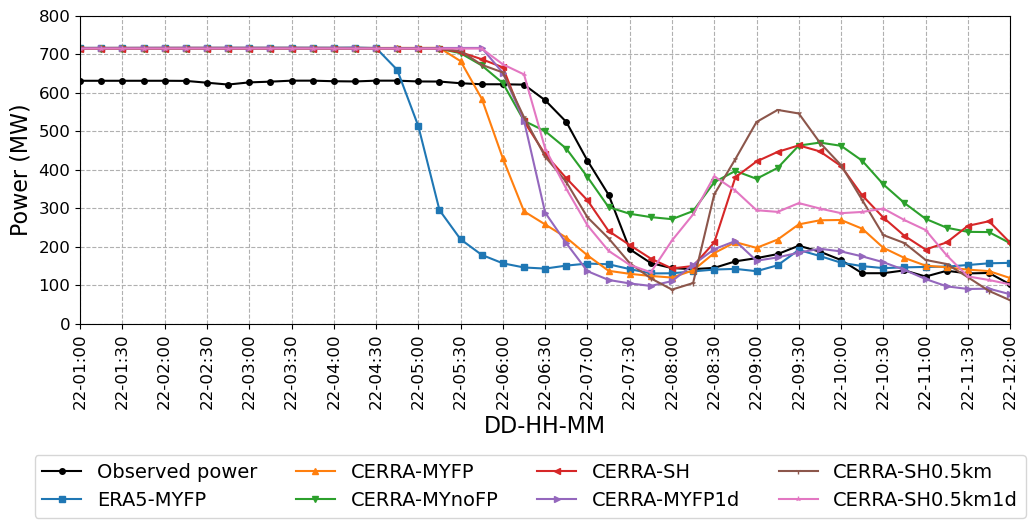

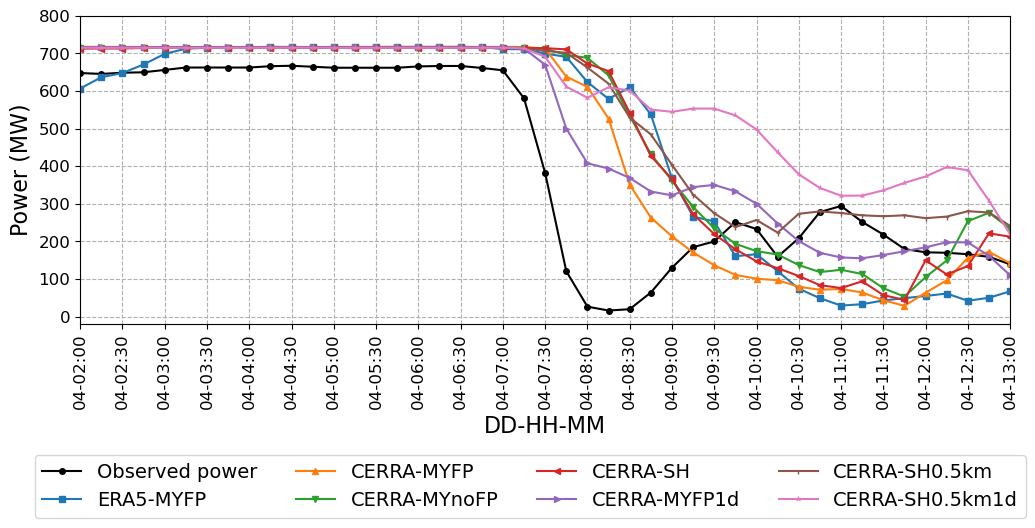

In [51]:
# create 10 custom colors, custom markers
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
for i,case in enumerate([1,2]):
    fig = plt.figure(figsize=(12, 4))
    gs = plt.GridSpec(1,1,hspace=0.4)
    ax = fig.add_subplot(gs[0])
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power.csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    for run in range(1,8):
        plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[run],'-',run_names[run-1],'',
                              xlabel='DD-HH-MM',ylabel='Power (MW)',xticks=True,yticks=np.arange(0, 801, 100),tick_interval=2)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.4),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_power_timeseries.pdf', dpi=300, bbox_inches='tight')

In [54]:
for case in [1,2]:
    my_list = []
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power.csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    times = pd.DataFrame(data.index)
    rated_power = 712.2
    obs_power = data[f'obs_power']
    cf_grid = obs_power/rated_power
    for j in [1,2,4]: #Loops through 15 min, 30min, and 1hr
        dmy = []
        del_cf_grid = np.array([(cf_grid.iloc[i+j]-cf_grid.iloc[i])*100 for i in range(len(cf_grid)-j)])
        dmy.append(round(np.min(del_cf_grid),1)*-1)
        dmy.append(times['times'].iloc[np.argmin(del_cf_grid)].strftime('%H:%M'))
        for run in range(1,8):
            label = run_names[run-1]
            wrf_power = data[f'{label}']
            cf_wrf = wrf_power/rated_power
            del_cf_wrf = np.array([(cf_wrf.iloc[i+j]-cf_wrf.iloc[i])*100 for i in range(len(cf_wrf)-j)])
            dmy.append(round(np.min(del_cf_wrf),1)*-1)
            dmy.append(times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%H:%M'))
        my_list.append(dmy)
    multiindex_tuples = []
    multiindex_tuples.append(('Grid_power', 'Delta_CF'))
    multiindex_tuples.append(('Grid_power', 'Time_instance'))
    for run in range(1,8):
        label = run_names[run-1]
        multiindex_tuples.append((label, 'Delta_CF'))
        multiindex_tuples.append((label, 'Time_instance'))
    columns = pd.MultiIndex.from_tuples(multiindex_tuples)
    index = ['15min','30min','1hr']
    df = pd.DataFrame(my_list,columns=columns,index=index)
    df.to_excel(f'{root_dir}/FLLJ_{case}/cf_ramp.xlsx')

In [25]:
df

Grid_power               ERA5-MYFP               CERRA-MYFP  \
        Delta_CF Time_instance  Delta_CF Time_instance   Delta_CF   
30min       32.3         07:00      51.2         04:45       41.1   
1hr         54.3         06:30      69.8         04:30       59.6   
2hr         67.3         06:15      80.4         04:30       81.3   

                    CERRA-MYnoFP               CERRA-SH                \
      Time_instance     Delta_CF Time_instance Delta_CF Time_instance   
30min         05:45         21.3         06:45     31.7         06:00   
1hr           05:15         34.2         06:00     48.5         06:00   
2hr           05:15         58.5         05:30     73.3         06:00   

      CERRA-MYFP1d               CERRA-SH0.5km               CERRA-SH0.5km1d  \
          Delta_CF Time_instance      Delta_CF Time_instance        Delta_CF   
30min         51.0         06:00          30.7         06:00            41.7   
1hr           72.3         06:00          52.8         06:00            64.3   
2hr           86.8         05:45          79.2         06:00            81.6   

                     
      Time_instance  
30min         06:15  
1hr           06:15  
2hr           05:45

# Time series of wind speed

In [55]:
obs_levels = [30,40,60,100,120,160,200] #the first level, 4 m is excluded
def obs_ws_wdir(start_time,end_time,levels,location):
    if (location=='LOT2'):
        df = pd.read_csv(f'{root_dir}/LIDARS/bwfz_20160404_fugro_metocean_campaign_ws156_location_2_period_1_v1-f/20160401_SDB_Fugro_WindResourceSpeedDirectionTIStat_OKS__lot2_V1_1_Final.csv', sep=';',skiprows=[0,1],index_col=0)
    else:
        df = pd.read_csv(f'{root_dir}/LIDARS/bwfz_20160404_fugro_metocean_campaign_ws157_location_1_period_5_v1-f/20160321_SDB_Fugro_WindResourceSpeedDirectionTIStat_OKS_V5_1_Final.csv', sep=';',skiprows=[0,1],index_col=0)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.loc[start_time:end_time]
    ws = {}
    wdir = {}
    for level in levels:
        if (level==4):
            ws[float(level)] = df.loc[start_time:end_time,f'WindSpeed{level:03d}m m/s']
            wdir[float(level)] = df.loc[start_time:end_time,f'WindDir{level:03d}m deg']
        else:
            ws[float(level)] = df.loc[start_time:end_time,f'WindSpeed{level:03d}mh m/s']
            wdir[float(level)] = df.loc[start_time:end_time,f'WindDir{level:03d}m deg']
    ws = pd.DataFrame(ws)
    wdir = pd.DataFrame(wdir)
    return ws,wdir

## Extract wind speed data and save to a dataframe dictonary

In [56]:
ws_dict = {}
for case in [1,2]:
    ws_dict[case] = {}
    case_dir = f'FLLJ_{case}'
    ws_dfs = {}
    for location in ['LOT1','LOT2']:
        ws_dfs[location] = []
        # observations
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        ws_dfs[location].append(obs_ws)
        # simulations
        for run in range(1,8):
            run_dir = f'WRF_run_{run}'
            u,v,_,_= extract_u_v(root_dir, case_dir,run,dates_range=ramp_periods[case-1],levels=[30,1100],location=buoy_locations[location])
            ws = wind_speed(u,v).drop_vars({'XLAT','XLONG'}).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='ws')
            ws_dfs[location].append(ws)
    ws_dict[case] = ws_dfs

Closest indices in the order of latitude (y) and longitude (x) are : (155, 126)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)
Closest indices in the order of latitude (y) and longitude (x) are : (324, 239)
Closest indices in the order of latitude (y) and longitude (x) are : (323, 236)
Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude

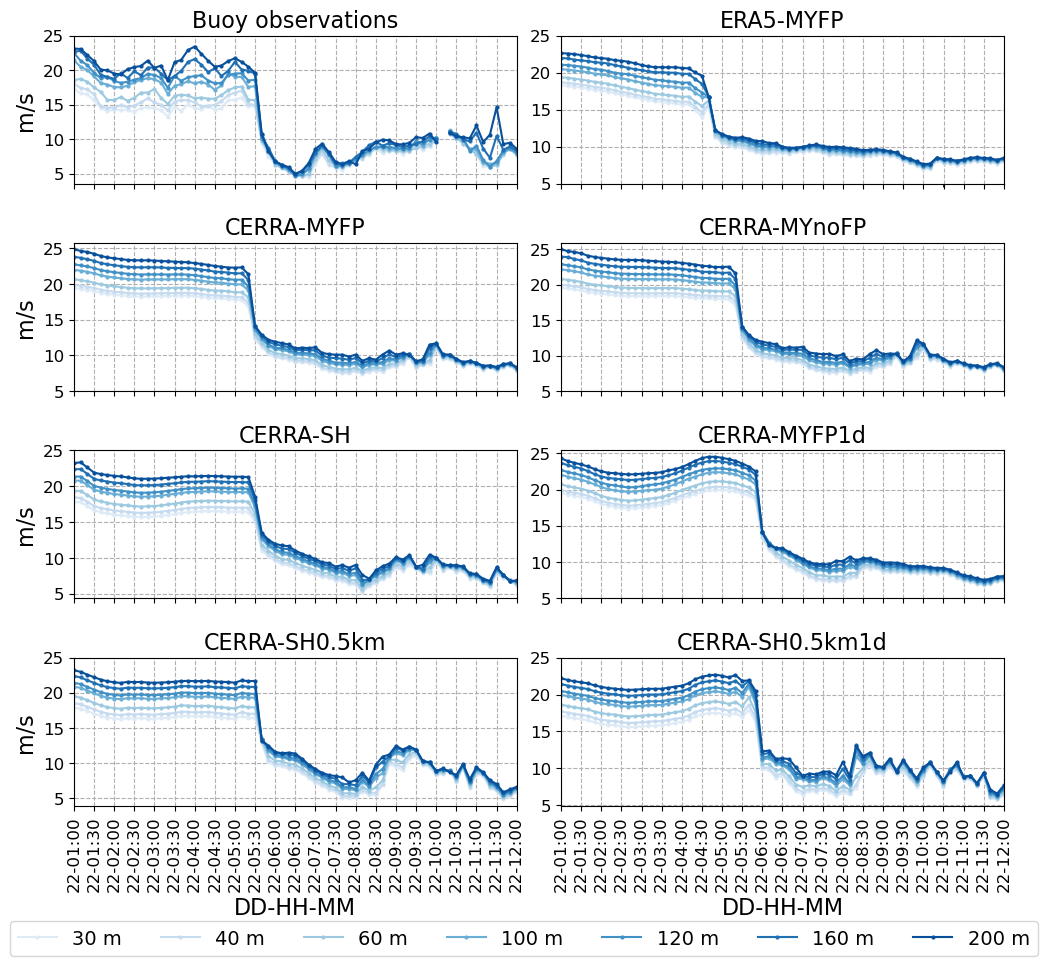

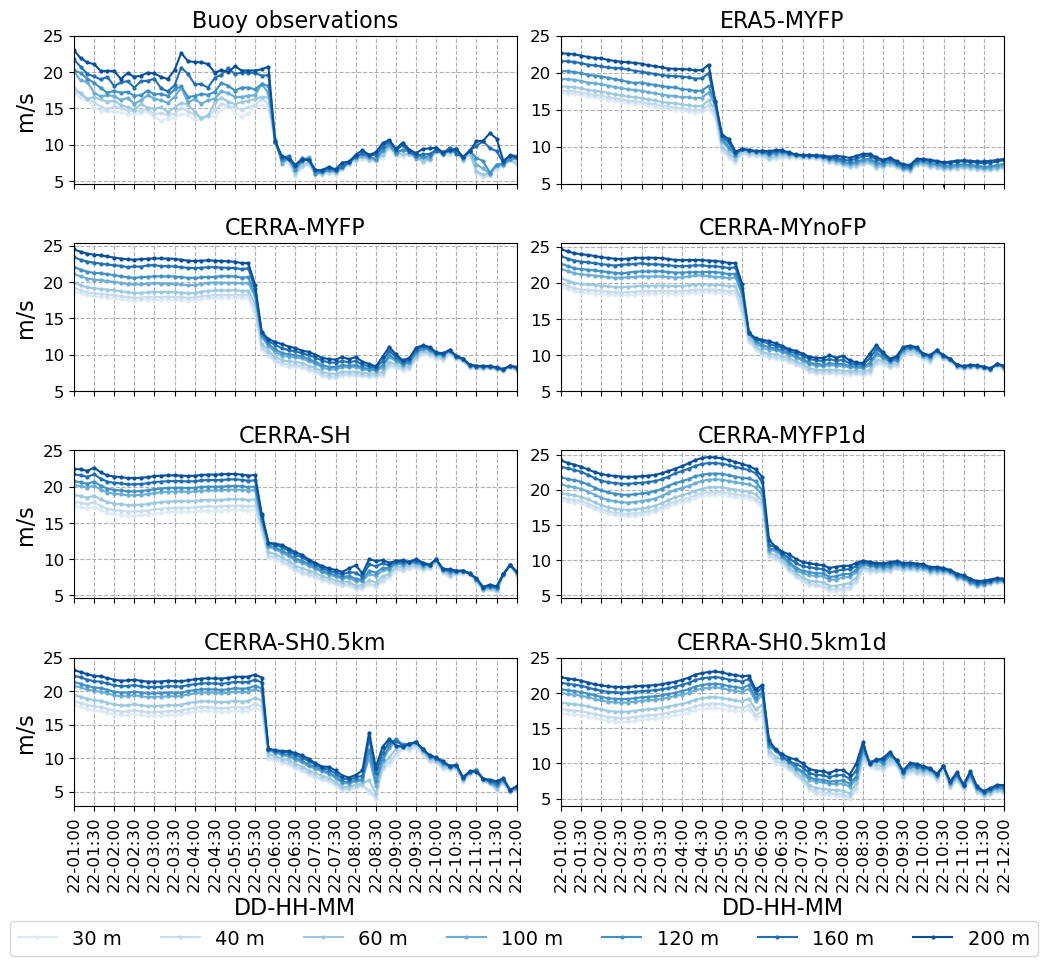

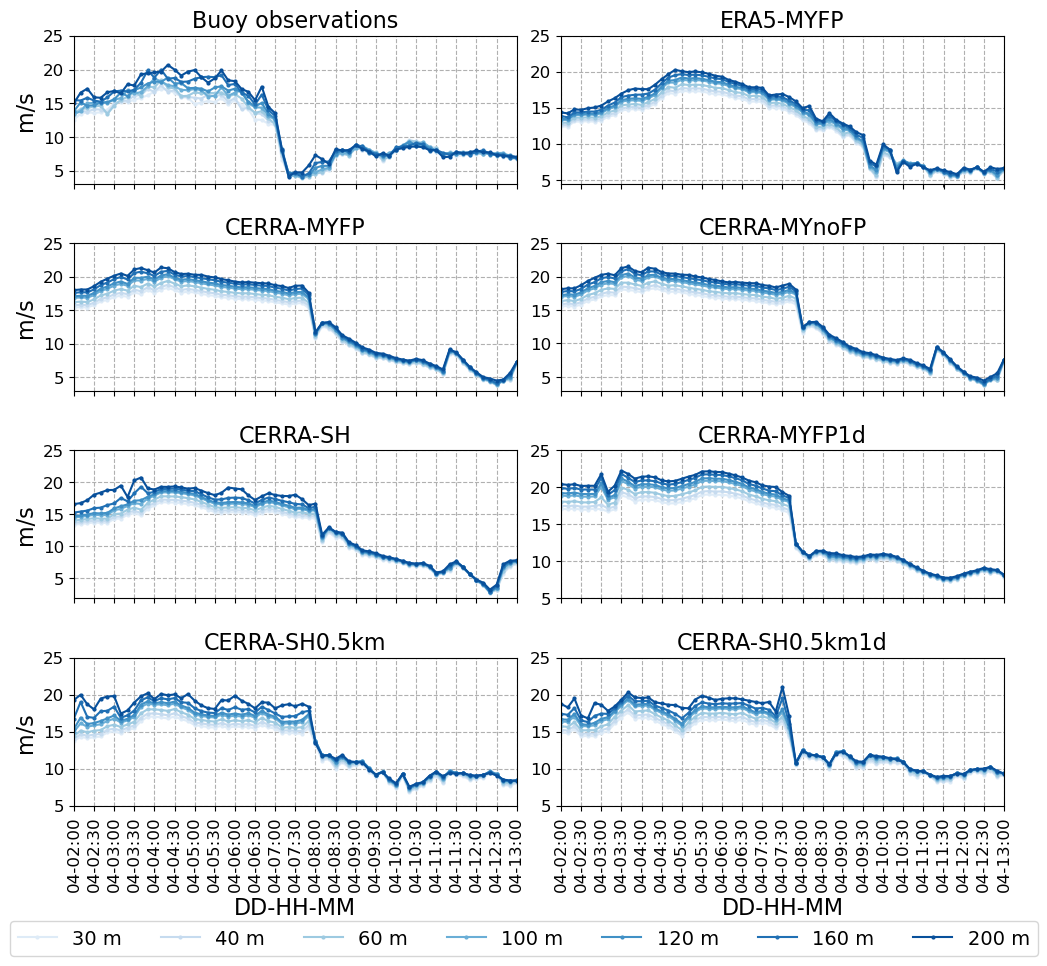

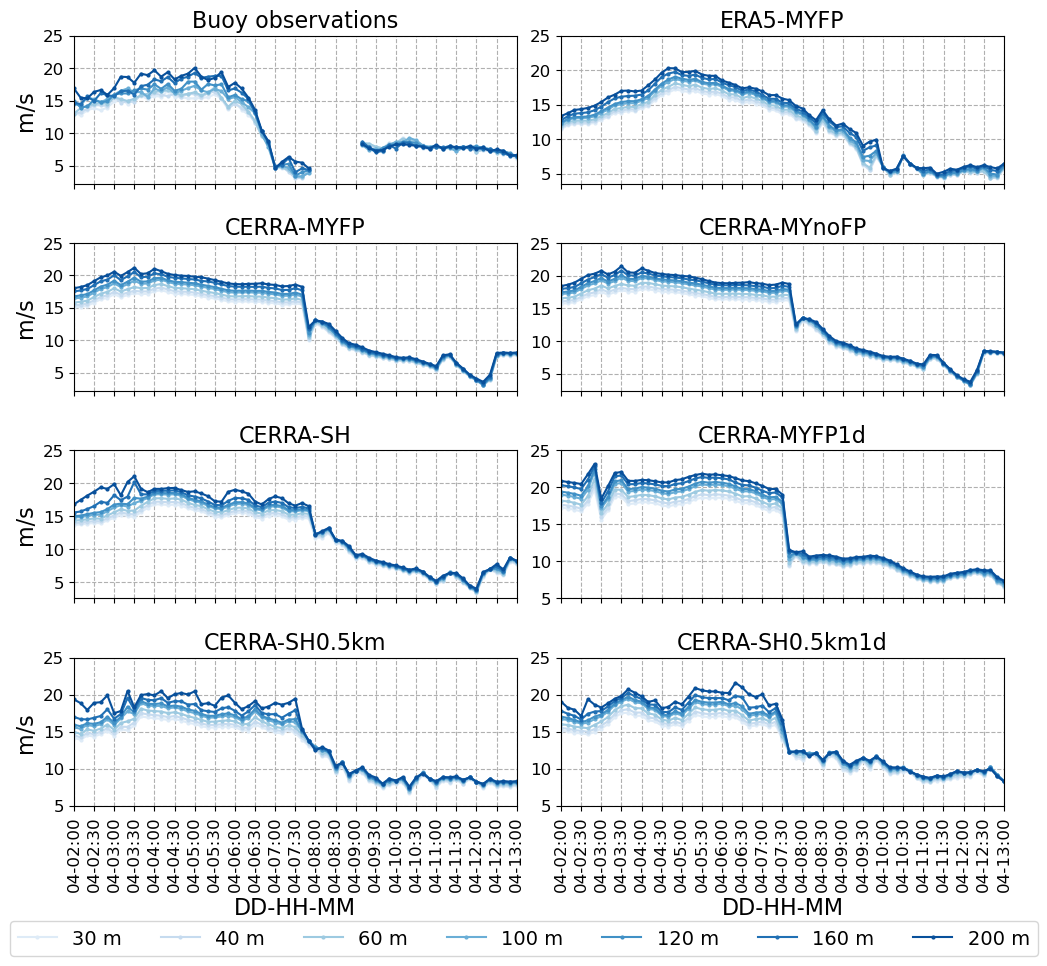

In [57]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    ws_dfs = ws_dict[case]
    for location in ['LOT1','LOT2']:
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Blues", len(obs_levels))
        fig = plt.figure(figsize=(12, 10))
        gs = plt.GridSpec(4,2,hspace=0.4, wspace=0.1)

        # observations
        obs_ws = ws_dfs[location][0]
        ax = fig.add_subplot(gs[0,0])
        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel='m/s',xticks=False,yticks=np.arange(5, 25.1, 5))
        j = 1
        for run in range(1,8):
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][run]
            ax = fig.add_subplot(gs[(j)//2,(j)%2])
            xlabel = 'DD-HH-MM' if j//2 == 3 else None
            ylabel = 'm/s' if j%2 == 0 else None
            xticks = True if j//2 == 3 else False
            for i,level in enumerate(obs_levels):
                plot_lines_timeseries(ax,ws.index[::2],ws[level][::2],colors[i],'.','-',f'{level} m',run_names[run-1],
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.05),fontsize=14)
        plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_speed_timeseries_{location}.pdf', dpi=300, bbox_inches='tight')

## Extract wind direction data and save to da dataframe dictonary

In [58]:
wdir_dict = {}
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    wdir_dict[case] = {}
    wdir_dfs = {}
    for location in ['LOT1','LOT2']:
        wdir_dfs[location] = []
        # observations
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        wdir_dfs[location].append(obs_wdir)
        # simulations
        for run in range(1,8):
            run_dir = f'WRF_run_{run}'
            u,v,_,_= extract_u_v(root_dir, case_dir,run,dates_range=ramp_periods[case-1],levels=[30,1100],location=buoy_locations[location])
            wdir = wind_direction(u,v).drop_vars({'XLAT','XLONG'}).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='wdir')
            wdir_dfs[location].append(wdir)
    wdir_dict[case] = wdir_dfs

Closest indices in the order of latitude (y) and longitude (x) are : (155, 126)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (164, 121)
Closest indices in the order of latitude (y) and longitude (x) are : (161, 118)
Closest indices in the order of latitude (y) and longitude (x) are : (324, 239)
Closest indices in the order of latitude (y) and longitude (x) are : (323, 236)
Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude

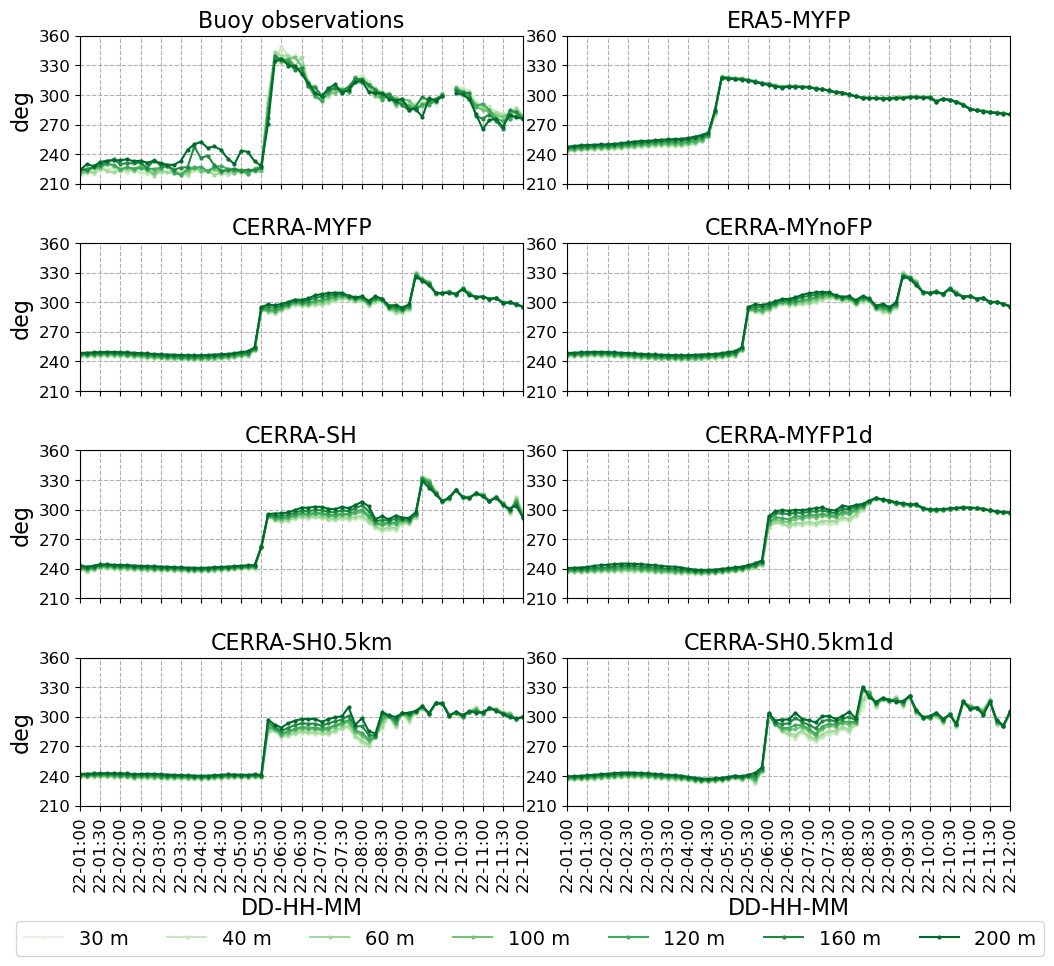

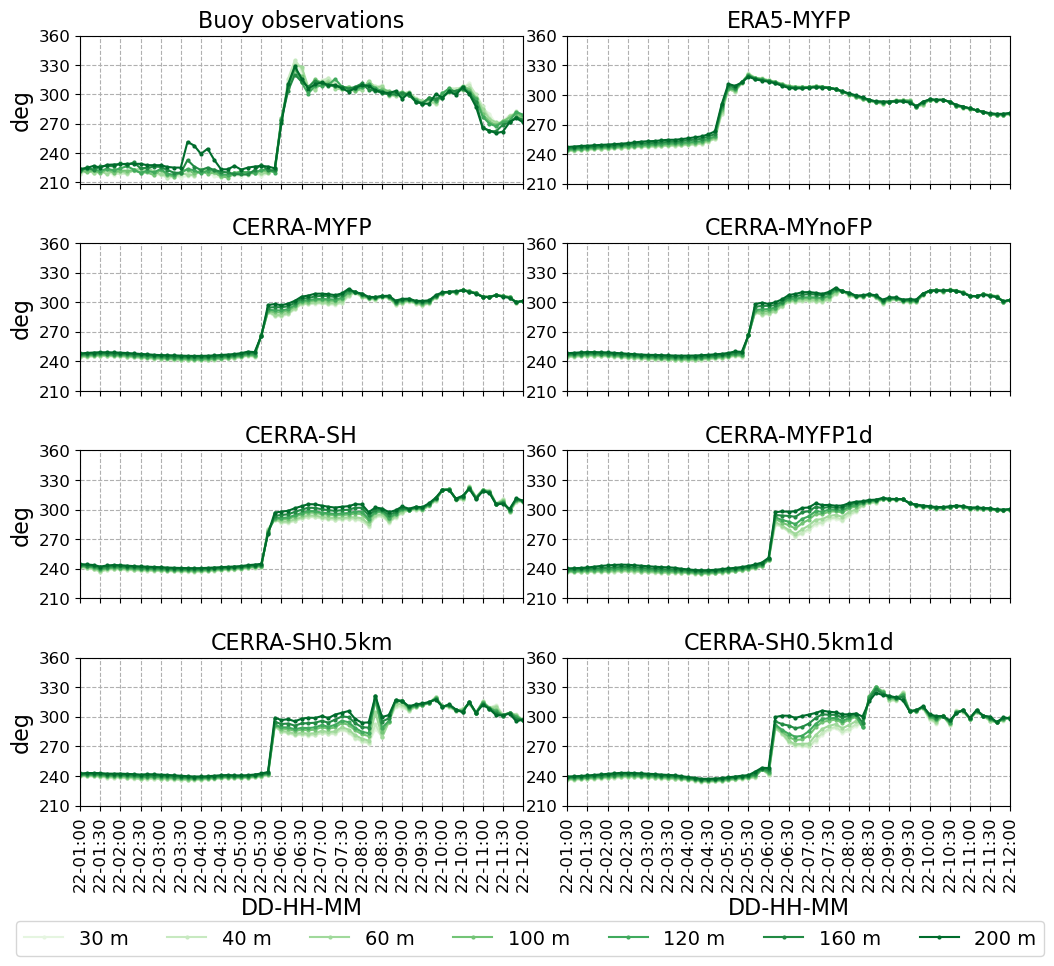

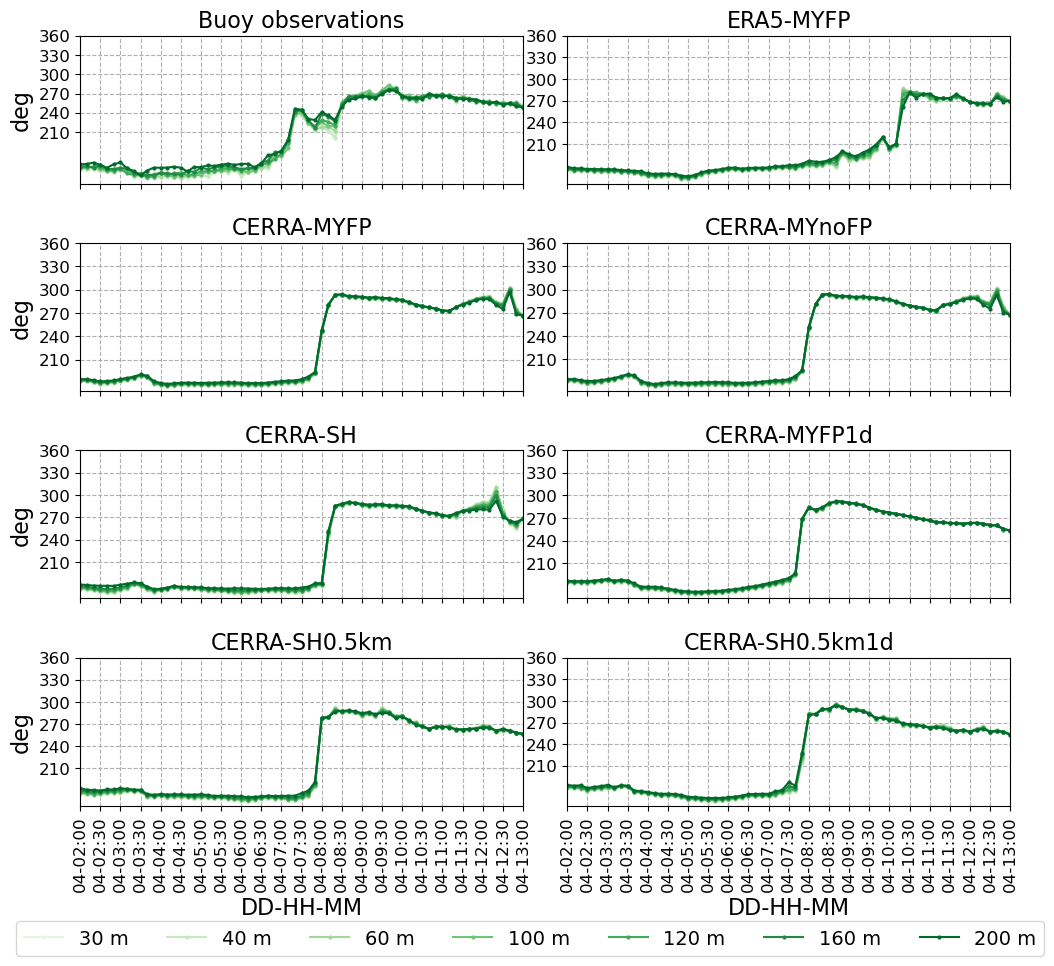

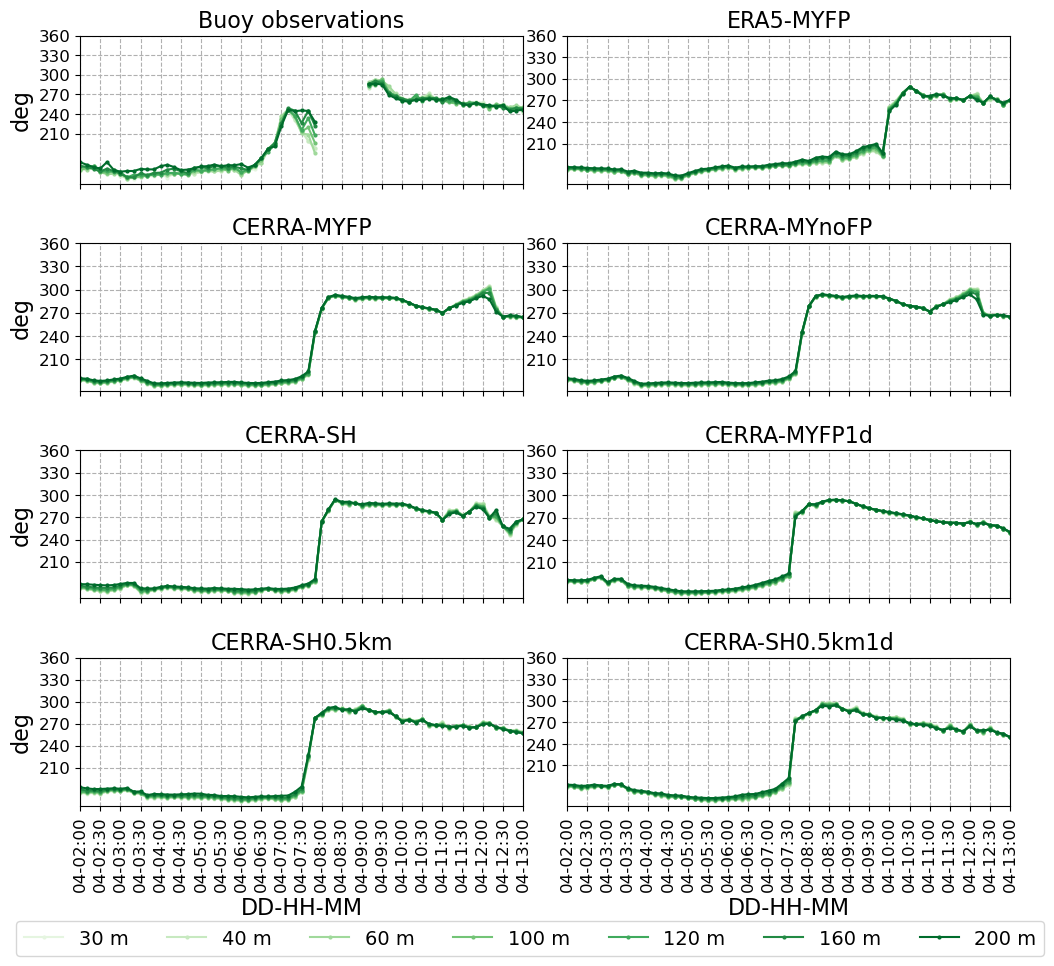

In [59]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    wdir_dfs = wdir_dict[case]
    for location in ['LOT1','LOT2']:
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Greens", len(obs_levels))
        fig = plt.figure(figsize=(12, 10))
        gs = plt.GridSpec(4,2,hspace=0.4, wspace=0.1)

        # observations
        obs_wdir = wdir_dfs[location][0]
        ax = fig.add_subplot(gs[0,0])
        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_wdir.index,obs_wdir[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel='deg',xticks=False,yticks=np.arange(210, 360.1, 30))
        j = 1
        for run in range(1,8):
            run_dir = f'WRF_run_{run}'
            wdir = wdir_dfs[location][run]
            ax = fig.add_subplot(gs[(j)//2,(j)%2])
            xlabel = 'DD-HH-MM' if j//2 == 3 else None
            ylabel = 'deg' if j%2 == 0 else None
            xticks = True if j//2 == 3 else False
            for i,level in enumerate(obs_levels):
                plot_lines_timeseries(ax,wdir.index[::2],wdir[level][::2],colors[i],'.','-',f'{level} m',run_names[run-1],
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(210, 360.1, 30))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.05),fontsize=14)
        plt.savefig(f'{fig_dir}/FLLJ_{case}_wind_direction_timeseries_{location}.pdf', dpi=300, bbox_inches='tight')

# Estimate error metric
- For plotting, time instance is not an issue, but for estimating a metric, the simulations and observations should be on same time
- Better create a combined dataframe

### wind power

In [60]:
for case in [1,2]:
    grid_power = pd.read_csv(f'{root_dir}/FLLJ_{case}/wind_power.csv',index_col=0)
    grid_power.index = pd.to_datetime(grid_power.index)
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    for run in range(1,8):
        SIM = data[f'{run_names[run-1]}']
        OBS = data['obs_power']
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[NRMSE(OBS,SIM),NBIAS(OBS,SIM),NPE(OBS,SIM),Taylor_Skill_Score(OBS,SIM)]],columns=['NRMSE','NBIAS','NPE','TSS'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
    df_all.to_csv(f'{root_dir}/{case_dir}/power_stats.csv')
    print(df_all)

                    NRMSE     NBIAS       NPE       TSS
ERA5-MYFP        0.517335  0.001589  0.248382  0.757830
CERRA-MYFP       0.341779 -0.000873  0.115587  0.880803
CERRA-MYnoFP     0.474548 -0.012918  0.094259  0.889351
CERRA-SH         0.398766 -0.008824  0.092309  0.908557
CERRA-MYFP1d     0.292264 -0.000832  0.084763  0.898368
CERRA-SH0.5km    0.429525 -0.004746  0.137259  0.866297
CERRA-SH0.5km1d  0.325452 -0.008896  0.067134  0.933631
                    NRMSE     NBIAS       NPE       TSS
ERA5-MYFP        0.570209 -0.001325  0.302040  0.712268
CERRA-MYFP       0.475023 -0.001635  0.208658  0.791906
CERRA-MYnoFP     0.583400 -0.002499  0.278107  0.740596
CERRA-SH         0.575923 -0.002063  0.284868  0.732255
CERRA-MYFP1d     0.421230 -0.005922  0.118845  0.883644
CERRA-SH0.5km    0.633035 -0.004729  0.251455  0.751148
CERRA-SH0.5km1d  0.812380 -0.006342  0.314982  0.629256


### wind speed

In [61]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    ws_dfs = ws_dict[case]
    for run in range(1,8):
        OBS = []
        SIM = []
        for location in ['LOT1','LOT2']:
            obs = ws_dfs[location][0].copy()
            sim = ws_dfs[location][run].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
        OBS = np.array(OBS)
        SIM = np.array(SIM)
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[NRMSE(OBS,SIM),NBIAS(OBS,SIM),NPE(OBS,SIM),Taylor_Skill_Score(OBS,SIM)]],columns=['NRMSE','NBIAS','NPE','TSS'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
    df_all.to_csv(f'{root_dir}/{case_dir}/ws_stats.csv')
    print(df_all)

                    NRMSE     NBIAS       NPE       TSS
ERA5-MYFP        0.400646  0.008322  0.160429  0.845526
CERRA-MYFP       0.338504 -0.418454  0.067908  0.926616
CERRA-MYnoFP     0.366344 -0.452171  0.071980  0.921007
CERRA-SH         0.262567 -0.230089  0.058870  0.939607
CERRA-MYFP1d     0.397265 -0.314402  0.098059  0.887423
CERRA-SH0.5km    0.297982 -0.245838  0.071230  0.924309
CERRA-SH0.5km1d  0.344642 -0.279317  0.086458  0.912421
                    NRMSE     NBIAS       NPE       TSS
ERA5-MYFP        0.592204 -0.070596  0.326716  0.699259
CERRA-MYFP       0.597812 -0.137804  0.279579  0.726712
CERRA-MYnoFP     0.618417 -0.147265  0.287783  0.719047
CERRA-SH         0.586236 -0.088704  0.309171  0.713326
CERRA-MYFP1d     0.681554 -0.317159  0.221973  0.784292
CERRA-SH0.5km    0.627826 -0.207128  0.270792  0.743024
CERRA-SH0.5km1d  0.679306 -0.309952  0.247237  0.753004


### wind direction

In [62]:
for case in [1,2]:
    case_dir = f'FLLJ_{case}'
    wdir_dfs = wdir_dict[case]
    for run in range(1,8):
        OBS = []
        SIM = []
        for location in ['LOT1','LOT2']:
            obs = wdir_dfs[location][0].copy()
            sim = wdir_dfs[location][run].copy()
            sim.index = sim.index.floor('min')
            sim = sim.loc[obs.index,obs.columns]
            obs.columns = pd.MultiIndex.from_tuples([('obs', col) for col in obs.columns])
            sim.columns = pd.MultiIndex.from_tuples([('sim', col) for col in sim.columns])
            merged = pd.merge(obs, sim, left_index=True, right_index=True)
            merged = merged.dropna()
            obs = merged['obs'].stack()
            sim = merged['sim'].stack()
            OBS.extend(obs.values)
            SIM.extend(sim.values)
        OBS = np.array(OBS)
        SIM = np.array(SIM)
        # crete a dataframe from these three statistics save to a excel
        df = pd.DataFrame([[NRMSE(OBS,SIM),NBIAS(OBS,SIM),NPE(OBS,SIM),Taylor_Skill_Score(OBS,SIM)]],columns=['NRMSE','NBIAS','NPE','TSS'],index=[run_names[run-1]])
        # combine dfs for all runs
        if run == 1:
            df_all = df
        else:
            df_all = pd.concat([df_all,df])
    df_all.to_csv(f'{root_dir}/{case_dir}/wdir_stats.csv')
    print(df_all)

                    NRMSE     NBIAS       NPE       TSS
ERA5-MYFP        0.693445 -0.019572  0.367002  0.593053
CERRA-MYFP       0.467656 -0.034948  0.151526  0.809629
CERRA-MYnoFP     0.467303 -0.037838  0.145237  0.819337
CERRA-SH         0.440436 -0.021805  0.162274  0.818120
CERRA-MYFP1d     0.403098 -0.013283  0.152232  0.824464
CERRA-SH0.5km    0.439522 -0.014671  0.176514  0.799841
CERRA-SH0.5km1d  0.434330 -0.012716  0.175593  0.814171
                    NRMSE     NBIAS       NPE       TSS
ERA5-MYFP        0.507244  0.001151  0.256880  0.746967
CERRA-MYFP       0.404414 -0.036825  0.096241  0.905219
CERRA-MYnoFP     0.405598 -0.038045  0.094563  0.907134
CERRA-SH         0.359594 -0.021745  0.102038  0.900538
CERRA-MYFP1d     0.377780 -0.030574  0.097914  0.897909
CERRA-SH0.5km    0.361363 -0.019875  0.106850  0.894212
CERRA-SH0.5km1d  0.353353 -0.018878  0.104504  0.896017


# wind speed profile

In [64]:
def plot_wind_profile(ax, data, levels, color, marker, label, xlabel, ylabel, title, xticks, yticks):
    ax.plot(data, levels, '-', color=color, marker=marker, label=label, markersize=4, linewidth=2)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=16)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=16)
    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    return ax

2016-02-22T01:00
2016-02-22T02:00
2016-02-22T03:00
2016-03-04T02:30
2016-03-04T03:30
2016-03-04T04:30
2016-02-22T01:00
2016-02-22T02:00
2016-02-22T03:00
2016-03-04T02:30
2016-03-04T03:30
2016-03-04T04:30


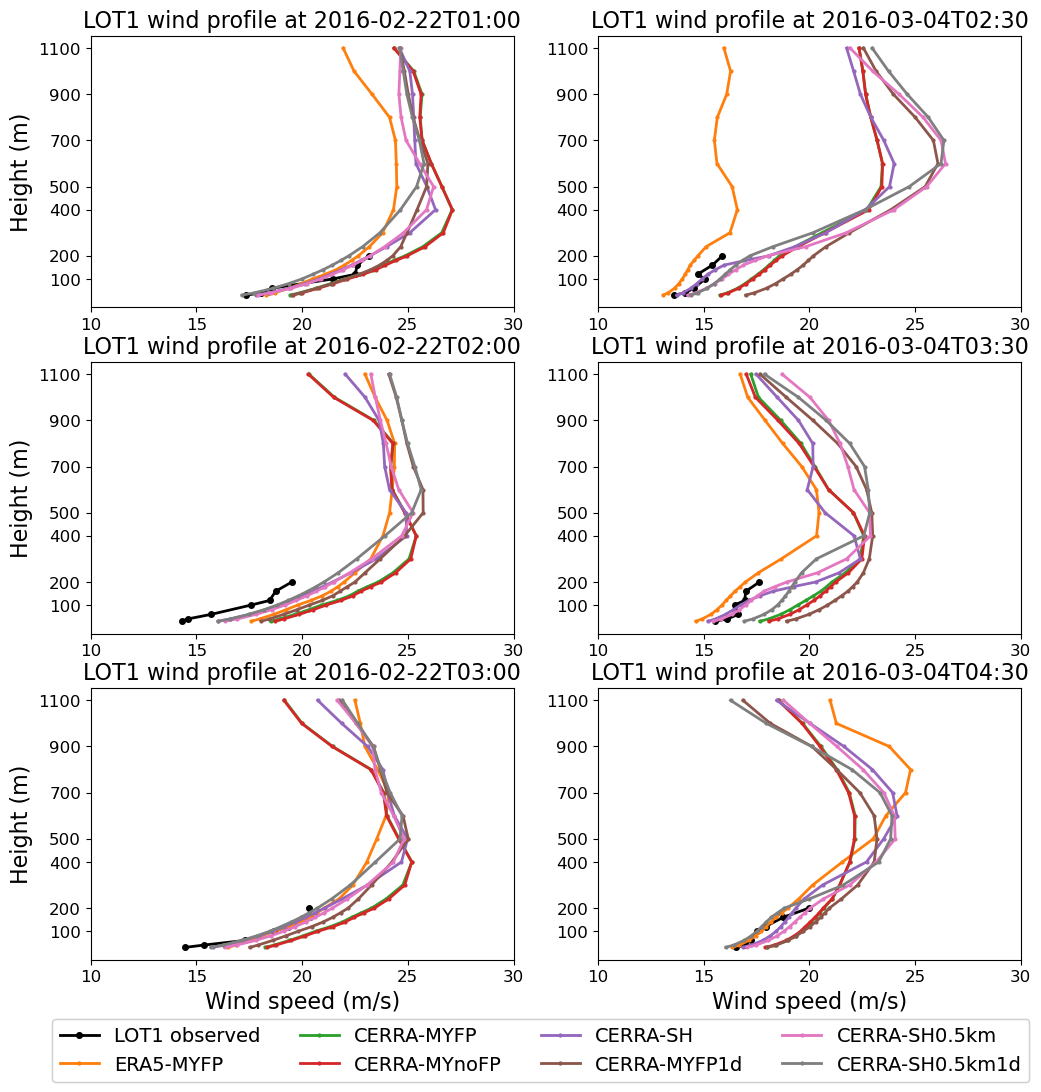

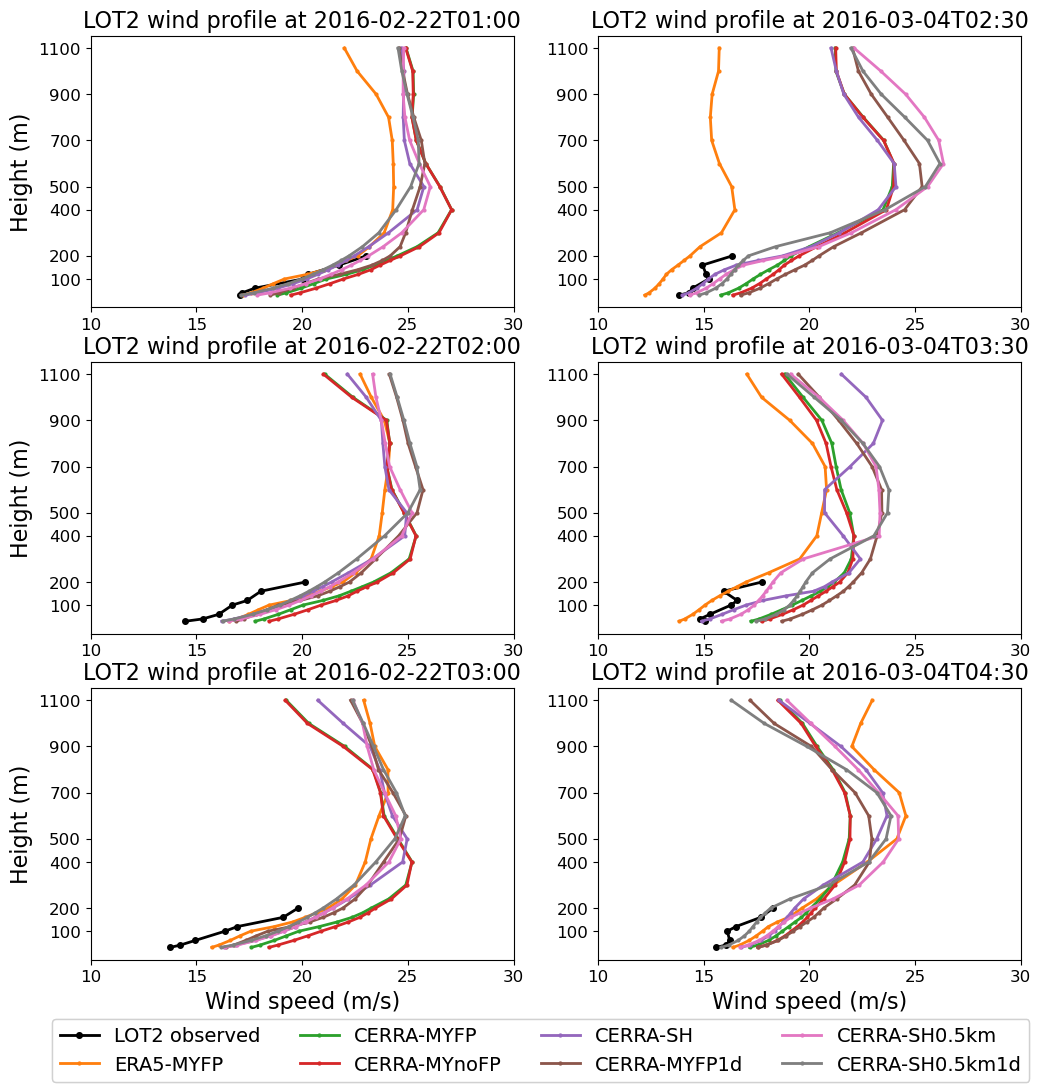

In [65]:
# create 10 colors and 10 markers
colors = sns.color_palette("tab10", 10)
markers = ['o','s','^','v','<','>','1','2','3','4','5']

for location in ['LOT1','LOT2']:
    fig = plt.figure(figsize=(12, 12))
    gs = plt.GridSpec(3,2)
    for i,case in enumerate([1,2]):
        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        for j,hour in enumerate(range(5,2,-1)):
            instance = ((datetime.strptime(time_instances[case-1], '%Y-%m-%dT%H:%M'))-timedelta(hours=hour)).strftime('%Y-%m-%dT%H:%M')
            print(instance)

            xlabel = 'Wind speed (m/s)' if j == 2 else None
            ylabel = 'Height (m)' if i == 0 else None
            title = f'{location} wind profile at {instance}'
            xticks = np.arange(10,30.1,5)
            yticks = [100, 200, 400, 500, 700, 900, 1100]
            ax = fig.add_subplot(gs[j,i])

            OBS = ws_dfs[location][0][instance:instance]
            plot_wind_profile(ax,np.squeeze(OBS.values), OBS.columns,'black', 'o', f'{location} observed', xlabel, ylabel, title, xticks, yticks)
            for run in range(1,8):
                run_dir = f'WRF_run_{run}'
                SIM = ws_dfs[location][run][instance:instance]
                plot_wind_profile(ax,np.squeeze(SIM.values),SIM.columns,colors[run],'.',run_names[run-1],xlabel, ylabel, title, xticks, yticks)

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.0),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_{location}_jet_wind_speed_profiles.pdf', dpi=300, bbox_inches='tight')

# Time series of wind speed for different events
- The UU and VV tslist files contain vertical levels:
- 2, 10, 30, 40, 60, 80, 100, 120, 150, 180, 200, 240, 300, 400, 500, 600, 700, 800, 900, 1000, 1100

In [215]:
tslist_height_levels = [2.0, 10.0, 30.0, 40.0, 60.0, 80.0, 100.0, 
                        120.0, 150.0, 180.0, 200.0, 240.0, 300.0, 400.0, 500.0, 
                        600.0, 700.0, 800.0, 900.0, 1000.0]
# unfortunately, the 1100.0 level hasn't been extracted
def extract_tslist_ws_wdir(root_dir,location,tslist_height_levels,start_time,end_time):
    UU = pd.read_csv(f'{root_dir}/tslist_data_from_WRF_SCORES/{location}_UU.csv',index_col=0)
    UU.index = pd.to_datetime(UU.index)
    UU = UU.loc[start_time:end_time].iloc[::10,1:] # sadly, the first column is timestep, so have to exclude. Also, we need data at every 10 minutes, but our df is saved at every minute.
    UU.columns = tslist_height_levels
    UU.index.names = ['Time']
    
    VV = pd.read_csv(f'{root_dir}/tslist_data_from_WRF_SCORES/{location}_VV.csv',index_col=0)
    VV.index = pd.to_datetime(VV.index)
    VV = VV.loc[start_time:end_time].iloc[::10,1:] # sadly, the first column is timestep, so have to exclude. Also, we need data at every 10 minutes, but our df is saved at every minute.
    VV.columns = tslist_height_levels
    VV.index.names = ['Time']

    ws = np.sqrt(UU**2+VV**2)
    wdir = np.mod(180+np.rad2deg(np.arctan2(UU, VV)),360)
    
    return ws,wdir

In [237]:
tslist_ws_dfs = {}
tslist_wdir_dfs = {}
for location in ['LOT1','LOT2']:
    tslist_ws_dfs[location] = []
    tslist_wdir_dfs[location] = []
    
    ws,wdir = extract_tslist_ws_wdir(root_dir,location,tslist_height_levels,ramp_periods[case-1][0],ramp_periods[case-1][1])
    tslist_ws_dfs[location].append(ws)
    tslist_wdir_dfs[location].append(wdir)

In [242]:
ramp_periods = [['2016-02-22T01:00','2016-02-22T12:00'],['2016-03-04T02:00','2016-03-04T13:00'],
                ['2016-02-09T03:00','2016-02-09T15:00']]

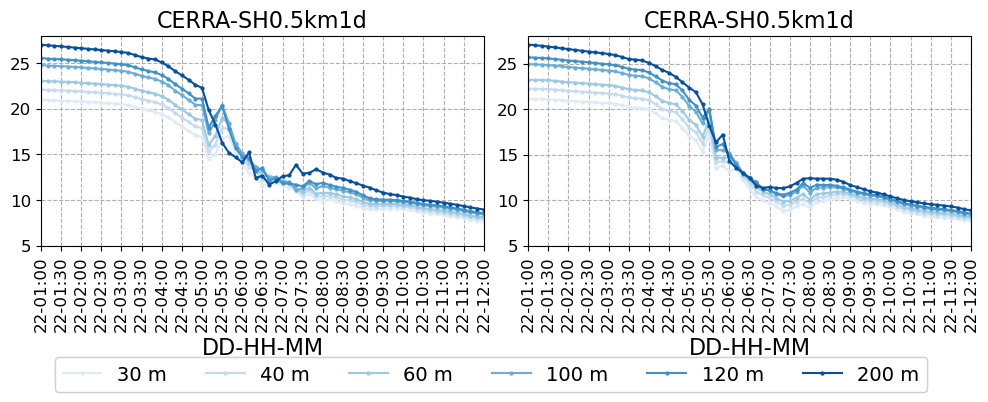

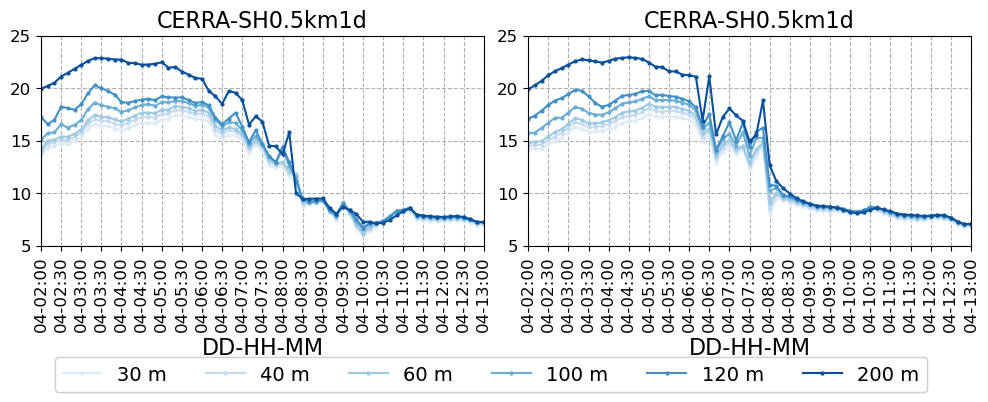

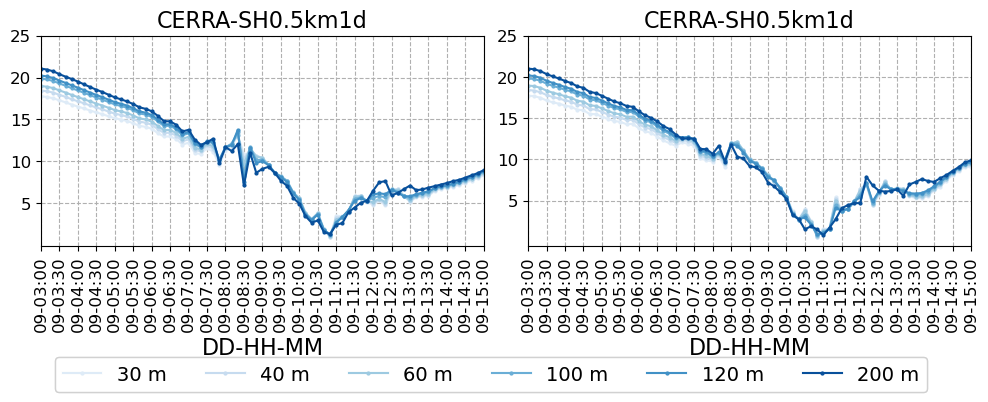

In [243]:
for case in range(1,4):
    case_dir = f'FLLJ_{case}'
    # create a set of 10 colors in blue, from light to dark
    colors = sns.color_palette("Blues", len(obs_levels))
    fig = plt.figure(figsize=(12, 6))
    gs = plt.GridSpec(2,2,hspace=0.2, wspace=0.1)

    tslist_ws_dfs = {}
    tslist_wdir_dfs = {}
    for location in ['LOT1','LOT2']:
        tslist_ws_dfs[location] = []
        tslist_wdir_dfs[location] = []
        
        ws,wdir = extract_tslist_ws_wdir(root_dir,location,tslist_height_levels,ramp_periods[case-1][0],ramp_periods[case-1][1])
        tslist_ws_dfs[location].append(ws)
        tslist_wdir_dfs[location].append(wdir)

    for j,location in enumerate(['LOT1','LOT2']):

        # observations
        '''
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        ax = fig.add_subplot(gs[0,j])

        xlabel = 'DD-HH-MM'
        ylabel = 'm/s' if j == 0 else None
        xticks = True

        for i,level in enumerate(obs_levels):
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],colors[i],'.','-',f'{level} m','Buoy observations',
                                xlabel=None,ylabel=ylabel,xticks=False,yticks=np.arange(5, 25.1, 5))
        '''
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,-0.15),fontsize=14)

        ws = tslist_ws_dfs[location][0]
        ax = fig.add_subplot(gs[1,j])

        for i,level in enumerate(obs_levels):
            if level in ws.columns:
                plot_lines_timeseries(ax,ws.index,ws[level],colors[i],'.','-',f'{level} m',run_names[7-1],
                                xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))